# **СИИ lab2**

ФИО: Чэнь Жохань

ИСУ: 413107

### 0. import library

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

### 1. Класс модель

In [63]:
class KNN:
    def __init__(self, k=5, distance_metric = "euclidean", batch_size=100):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.type_task = None
        self.distance_metric = distance_metric
        self.batch_size = batch_size

    def calculate_distance(self, X_query):
        if self.distance_metric == 'euclidean':
            distances = torch.sqrt(torch.sum((X_query[:, None] - self.X_train) **2, dim=2))
        elif self.distance_metric == 'manhattan':
            distances = torch.sum(torch.abs(X_query[:, None] - self.X_train), dim=2)
            
        return distances

    def fit(self, X_train: torch.Tensor, y_train: torch.Tensor):
        self.X_train = X_train.to(dtype=torch.float32)
        
        if torch.is_floating_point(y_train):
            self.y_train = y_train.to(dtype=torch.float32)
            self.type_task = 'regression'
        else:
            self.y_train = y_train.to(dtype=torch.long)
            self.type_task = 'classification'

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = torch.tensor(X_test.values, dtype=torch.float32)
        else:
            X_test = X_test.clone().detach().to(dtype=torch.float32)
        
        all_predictions = []
        
        total_samples = X_test.shape[0]
        
        for start in range(0, total_samples, self.batch_size):
            end = min(start + self.batch_size, total_samples)
            X_batch = X_test[start:end]
            
            distances = self.calculate_distance(X_batch)
            
            _, k_neighbors_indices = torch.topk(distances, self.k, largest=False)
            
            k_neighbors_labels = self.y_train[k_neighbors_indices]
            
            if self.type_task == 'classification':
                batch_predictions = torch.zeros(X_batch.shape[0], dtype=torch.long)
                for i in range(X_batch.shape[0]):
                    counts = torch.bincount(k_neighbors_labels[i])
                    batch_predictions[i] = torch.argmax(counts)
            elif self.type_task == 'regression':
                batch_predictions = torch.mean(k_neighbors_labels.float(), dim=1)
            
            all_predictions.append(batch_predictions)
        
        return torch.cat(all_predictions, dim=0)
    
    def calculate_metrics(self, y_true, y_pred, type_task):
    
        if isinstance(y_true, pd.Series):
            if type_task == 'classification':
                y_true = torch.tensor(y_true.values, dtype=torch.long)
            else:
                y_true = torch.tensor(y_true.values, dtype=torch.float32)
        
        if isinstance(y_pred, pd.Series):
            if type_task == 'classification':
                y_pred = torch.tensor(y_pred.values, dtype=torch.long)
            else:
                y_pred = torch.tensor(y_pred.values, dtype=torch.float32)
        
        if isinstance(y_pred, torch.Tensor) and isinstance(y_true, torch.Tensor):
            y_pred = y_pred.to(y_true.device)
        
        metrics = {}
        
        if type_task == 'classification':
            correct = torch.sum(y_true == y_pred).item()
            total = y_true.numel()
            metrics['accuracy'] = correct / total
            
            classes = torch.unique(y_true)
            if len(classes) > 1:
                per_class_acc = []
                for cls in classes:
                    mask = (y_true == cls)
                    if mask.sum() > 0:
                        per_class_acc.append(torch.sum(y_pred[mask] == cls).item() / mask.sum().item())
                metrics['per_class_accuracy'] = per_class_acc
                metrics['macro_accuracy'] = sum(per_class_acc) / len(per_class_acc)
        
        else:
            # MSE
            mse = torch.mean((y_true - y_pred) ** 2)
            metrics['MSE'] = mse.item()
            
            # RMSE
            rmse = torch.sqrt(mse)
            metrics['RMSE'] = rmse.item()
            
            # MAE
            mae = torch.mean(torch.abs(y_true - y_pred))
            metrics['MAE'] = mae.item()
            
            # R²
            ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)
            ss_residual = torch.sum((y_true - y_pred) ** 2)
            r2 = 1 - (ss_residual / ss_total.clamp_min(1e-12))  # 防止除以零
            metrics['R2'] = r2.item()
        
        return metrics
    
    def evaluate(self, X, y, type_task):
        y_pred = self.predict(X)
        metrics = self.calculate_metrics(y, y_pred, type_task)
        return metrics, y_pred

### 2. Чтение датасет

In [64]:
data_insurance = pd.read_csv("insurance.csv")
data_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [65]:
data_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [66]:
data_insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [67]:
data_fashion = pd.read_csv('fashion-mnist_test.csv')
data_fashion.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
print('Строки и столбики:', data_fashion.shape)
data_fashion.info()

Строки и столбики: (10000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [69]:
data_fashion.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4.500000,0.000400,0.010300,0.052100,0.077000,0.208600,0.349200,0.826700,2.321200,5.457800,...,34.320800,23.071900,16.432000,17.870600,22.860000,17.790200,8.353500,2.541600,0.629500,0.06560
std,2.872425,0.024493,0.525187,2.494315,2.208882,4.669183,5.657849,8.591731,15.031508,23.359019,...,57.888679,49.049749,42.159665,44.140552,51.706601,45.128107,28.765769,16.417363,7.462533,1.93403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,2.000000,45.000000,218.000000,185.000000,227.000000,223.000000,247.000000,218.000000,244.000000,...,254.000000,252.000000,255.000000,255.000000,255.000000,255.000000,240.000000,225.000000,205.000000,107.00000


### 3. Обработка датасета

In [70]:
data_insurance.isnull().any(axis=0)

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [71]:
data_insurance_copy = data_insurance.copy().drop_duplicates()
data_insurance_copy.shape

(1337, 7)

In [72]:
data = {
    "region": ["southwest", "southeast", "northwest", "northeast"],
    "sex": ["female", "male"],
    "smoker": ["yes", "no"]
}

data_insurance_copy["region"], _ = pd.factorize(data_insurance_copy["region"])
data_insurance_copy["sex"], _ = pd.factorize(data_insurance_copy["sex"])
data_insurance_copy["smoker"], _ = pd.factorize(data_insurance_copy["smoker"])

data_insurance_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


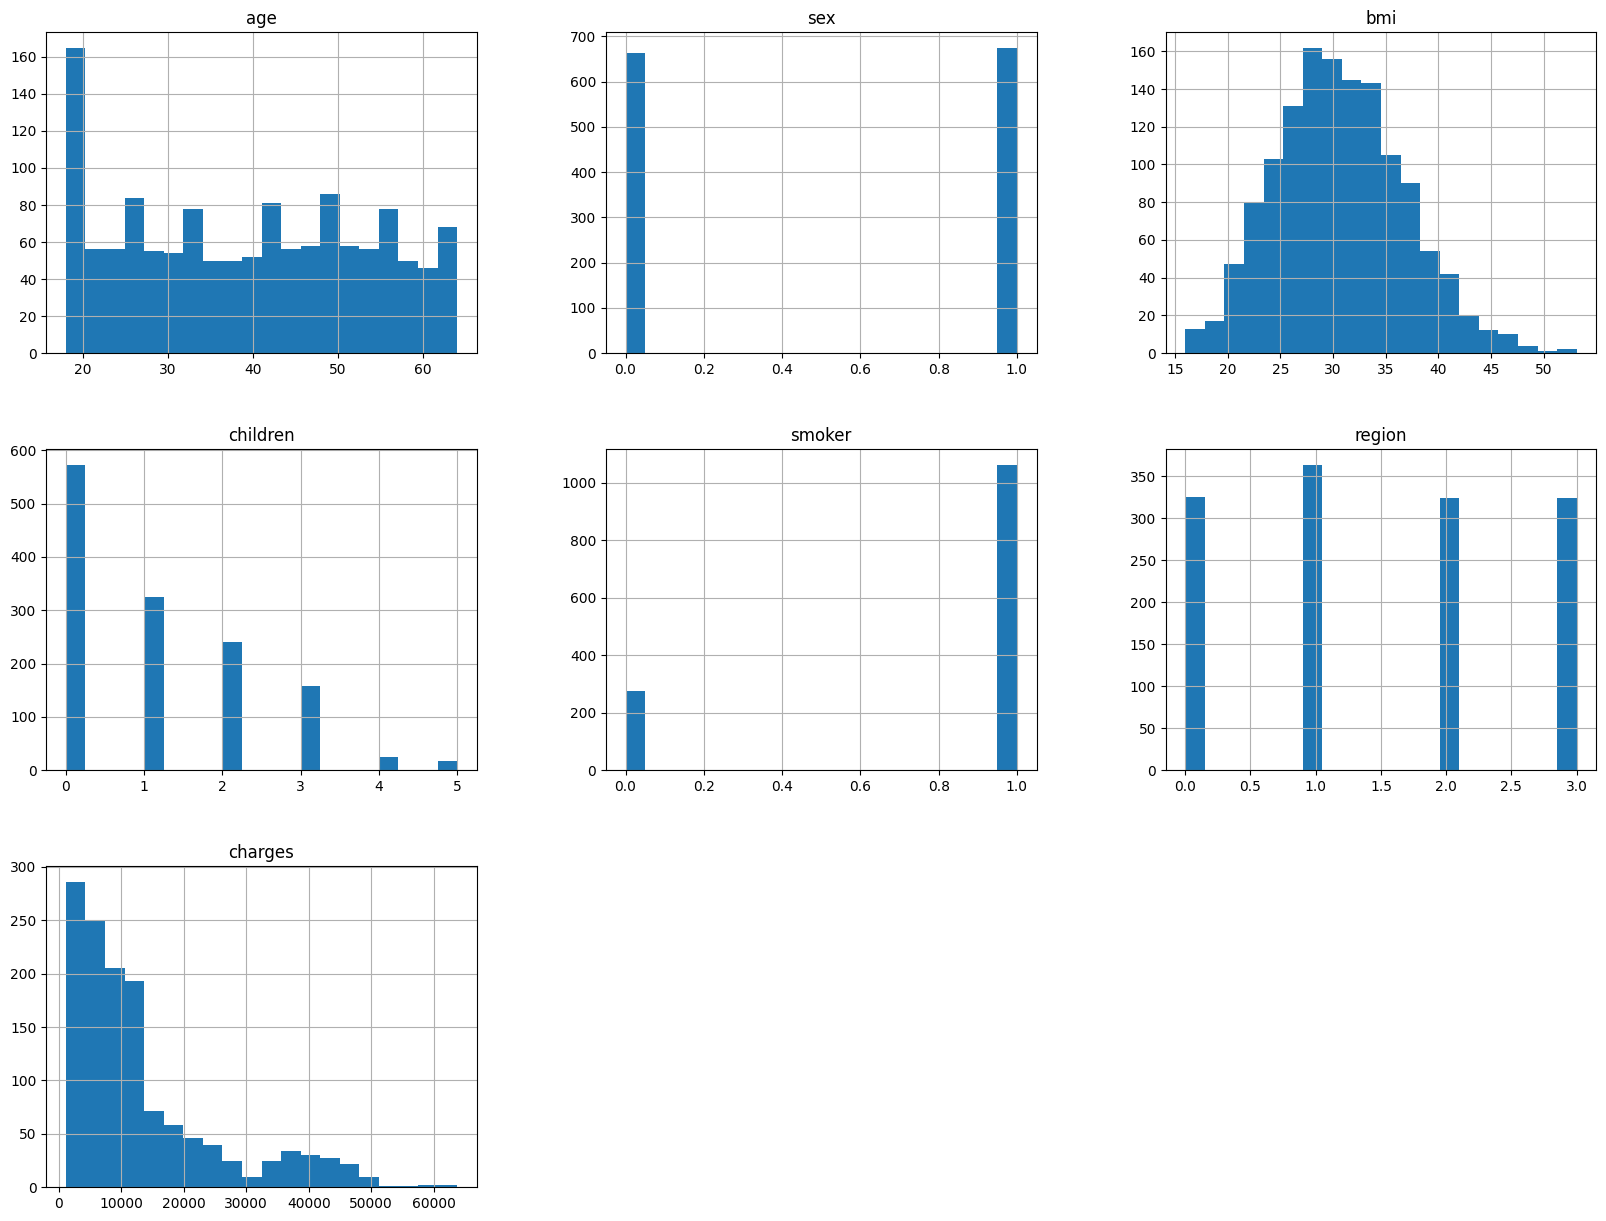

In [73]:
data_insurance_copy.hist(bins=20, figsize=(20, 15))
plt.show()

In [74]:
import numpy as np

plt.style.use('default')

def correlation_matrix(table):
    
    numeric_cols = table.select_dtypes(include=[np.number]).columns
    corr_matrix = table[numeric_cols].corr().values

    plt.figure(figsize=(14, 10))
    
    im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(im, label='Correlation коэф.')
    
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            plt.text(j, i, f'{corr_matrix[i, j]:.2f}', 
                    ha='center', va='center', 
                    color='white' if abs(corr_matrix[i, j]) > 0.5 else 'black')
    
    plt.title('Correlation matrix')
    plt.tight_layout()
    plt.show()

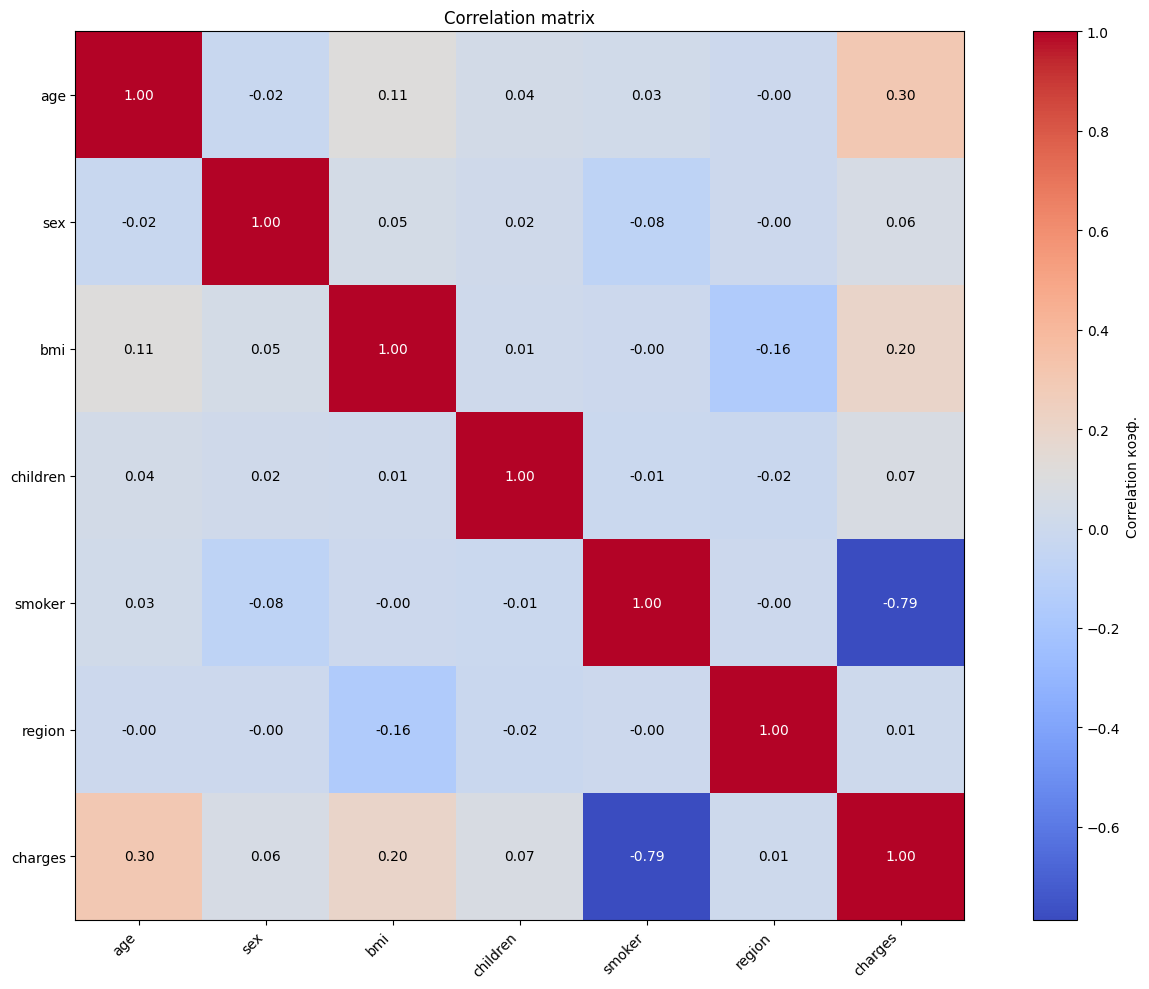

In [75]:
correlation_matrix(data_insurance_copy)

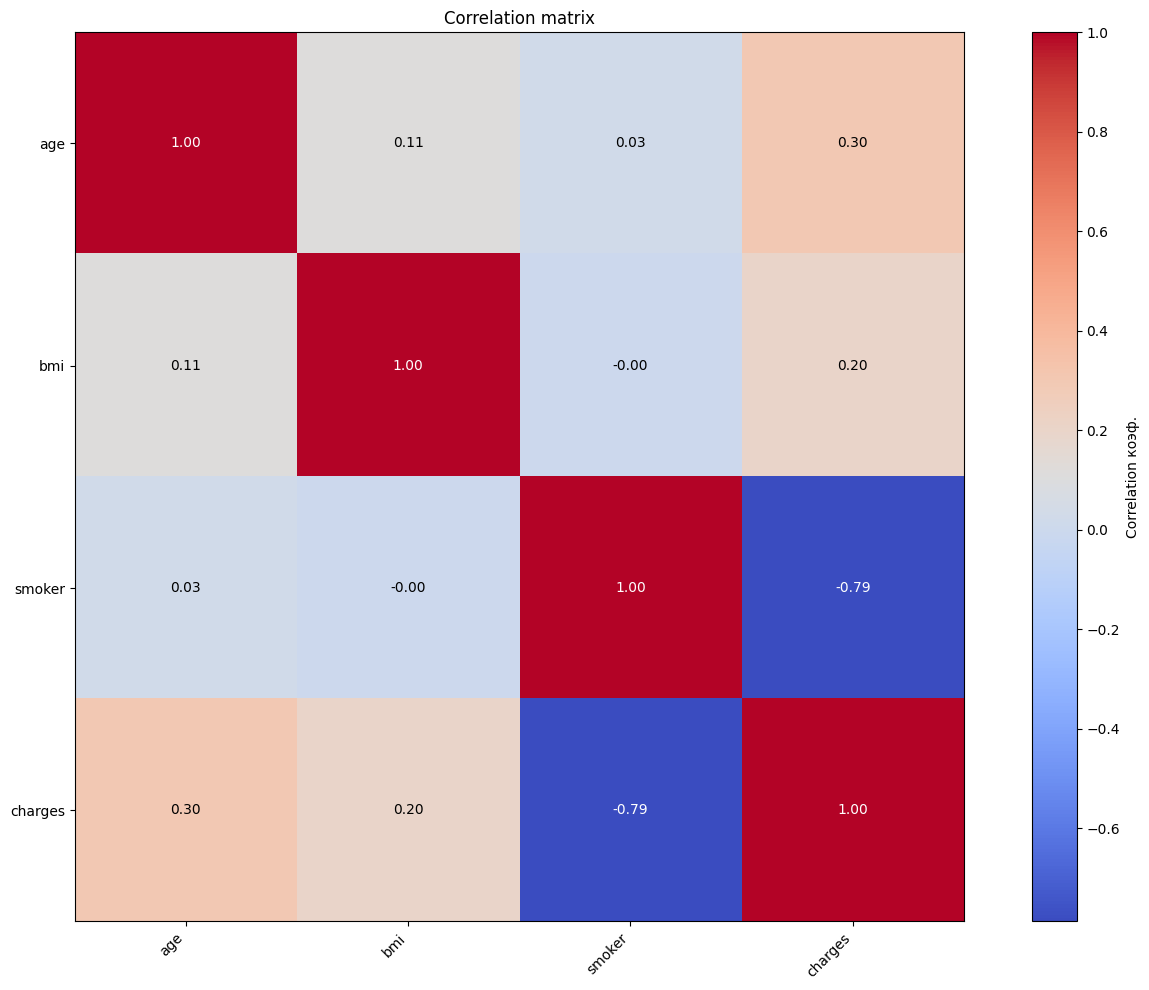

In [76]:
data_insurance_copy = data_insurance_copy.drop(columns=['sex', 'children', 'region'])

correlation_matrix(data_insurance_copy)

#### 4. Обучение датасета

In [77]:
X_ins = data_insurance_copy.drop('charges', axis=1)
y_ins = data_insurance_copy['charges']

X_ins_train, X_ins_test, y_ins_train, y_ins_test = train_test_split(
    X_ins, y_ins, test_size=0.2, random_state=42
)

X_train_mean = np.mean(X_ins_train, axis=0)
X_train_std = np.std(X_ins_train, axis=0)
X_train_standardized = (X_ins_train - X_train_mean) / X_train_std
X_test_standardized = (X_ins_test - X_train_mean) / X_train_std

X_ins_train = torch.tensor(X_train_standardized.values, dtype=torch.float32)
y_ins_train = torch.tensor(y_ins_train.values, dtype=torch.float32)
X_ins_test = torch.tensor(X_test_standardized.values, dtype=torch.float32)
y_ins_test = torch.tensor(y_ins_test.values, dtype=torch.float32)


knn_regressor = KNN(k=5, distance_metric='manhattan')
knn_regressor.fit(X_ins_train, y_ins_train)

y_ins_pred = knn_regressor.predict(X_ins_test)

ins_metrics = knn_regressor.calculate_metrics(y_ins_test, y_ins_pred, "regression")

In [78]:
metrics_train, y_train_pred = knn_regressor.evaluate(X_ins_train, y_ins_train, "regression")

metrics_pred, y_test_pred = knn_regressor.evaluate(X_ins_test, y_ins_test, "regression")

print("Метрики обучания:")
print(f"MSE: {metrics_train['MSE']:.2f}")
print(f"RMSE: {metrics_train['RMSE']:.2f}")
print(f"MAE: {metrics_train['MAE']:.2f}")
print(f"R²: {metrics_train['R2']:.4f}")

print("\nМетрики тестирование:")
print(f"MSE: {metrics_pred['MSE']:.2f}")
print(f"RMSE: {metrics_pred['RMSE']:.2f}")
print(f"MAE: {metrics_pred['MAE']:.2f}")
print(f"R²: {metrics_pred['R2']:.4f}")

Метрики обучания:
MSE: 18362844.00
RMSE: 4285.19
MAE: 2444.20
R²: 0.8659

Метрики тестирование:
MSE: 22091792.00
RMSE: 4700.19
MAE: 2796.63
R²: 0.8798


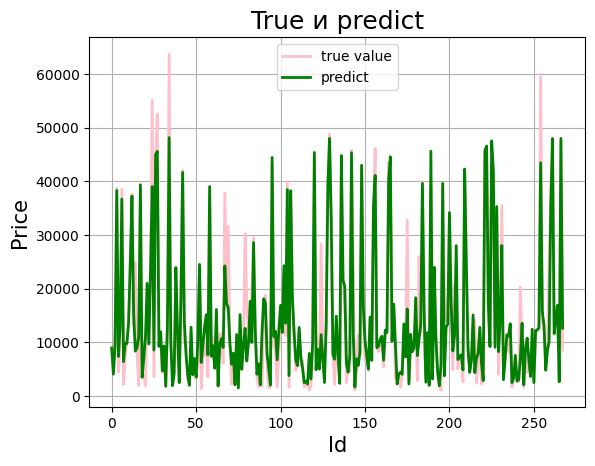

In [79]:
n_points = min(len(y_ins_test), len(y_test_pred))
t = np.arange(n_points)

plt.figure(facecolor='w')
plt.plot(t, y_ins_test[:n_points], 'pink', lw=2, label=u'true value')
plt.plot(t, y_test_pred[:n_points], 'green', lw=2, label=u'predict')
plt.legend(loc = 'best')
plt.title('True и predict', fontsize=18)
plt.xlabel('Id', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.grid()
plt.show()

In [80]:
X_fas = data_fashion.drop('label', axis=1)
y_fas = data_fashion['label']

X_fas_train, X_fas_test, y_fas_train, y_fas_test = train_test_split(
    X_fas, y_fas, test_size=0.2, random_state=42
)

X_fas_train_mean = np.mean(X_fas_train, axis=0)
X_fas_train_std = np.std(X_fas_train, axis=0)

X_fas_train_standardized = (X_fas_train - X_fas_train_mean) / X_fas_train_std
X_fas_test_standardized = (X_fas_test - X_fas_train_mean) / X_fas_train_std

X_fas_train = torch.tensor(X_fas_train_standardized.values, dtype=torch.float32)
y_fas_train = torch.tensor(y_fas_train.values, dtype=torch.long)
X_fas_test = torch.tensor(X_fas_test_standardized.values, dtype=torch.float32)
y_fas_test = torch.tensor(y_fas_test.values, dtype=torch.long)

knn_classfic = KNN(k=5, distance_metric='euclidean', batch_size=50)
knn_classfic.fit(X_fas_train, y_fas_train)

y_fas_pred = knn_classfic.predict(X_fas_test)

ins_metrics = knn_classfic.calculate_metrics(y_fas_test, y_fas_pred, "classification")

print("\nМетрики тестирование:")
print(f"Accuracy: {ins_metrics['accuracy']:.4f}")
print(f"Macro Accuracy: {ins_metrics['macro_accuracy']:.4f}")
print(f"Per-class Accuracy: {[round(acc, 4) for acc in ins_metrics['per_class_accuracy']]}")


Метрики тестирование:
Accuracy: 0.8340
Macro Accuracy: 0.8350
Per-class Accuracy: [0.8542, 0.9531, 0.7547, 0.8488, 0.75, 0.8497, 0.58, 0.9369, 0.8878, 0.935]


In [81]:
metrics_fas_train, y_fas_train_pred = knn_classfic.evaluate(X_fas_train, y_fas_train, "classification")

print("\nМетрики Обучение:")
print(f"Accuracy: {metrics_fas_train['accuracy']:.4f}")
print(f"Macro Accuracy: {metrics_fas_train['macro_accuracy']:.4f}")
print(f"Per-class Accuracy: {[round(acc, 4) for acc in metrics_fas_train['per_class_accuracy']]}")


Метрики Обучение:
Accuracy: 0.8755
Macro Accuracy: 0.8753
Per-class Accuracy: [0.9109, 0.9616, 0.8325, 0.8616, 0.8178, 0.8265, 0.685, 0.9534, 0.9366, 0.9675]


In [90]:
def plot_metrics(train_metrics, test_metrics, class_names=None):
    plt.figure(figsize=(10, 6))
    
    metrics_names = ['Accuracy', 'Macro Accuracy']
    train_values = [train_metrics['accuracy'], train_metrics['macro_accuracy']]
    test_values = [test_metrics['accuracy'], test_metrics['macro_accuracy']]
    
    x = np.arange(len(train_metrics['per_class_accuracy']))
    width = 0.35
    
    plt.subplot(1, 2, 1)
    plt.bar(x - width/2, train_metrics['per_class_accuracy'], width, label='Training', color='skyblue')
    plt.bar(x + width/2, test_metrics['per_class_accuracy'], width, label='Testing', color='lightgreen')
    plt.xticks(x, class_names if class_names else [f'Class {i}' for i in x], rotation=45)
    plt.ylabel('Accuracy')
    plt.title('Per-class Accuracy')
    plt.legend()
    plt.ylim(0, 1.0)
    
    plt.subplot(1, 2, 2)
    x_total = np.arange(len(metrics_names))
    plt.bar(x_total - width/2, train_values, width, label='Training', color='skyblue')
    plt.bar(x_total + width/2, test_values, width, label='Testing', color='lightgreen')
    plt.xticks(x_total, metrics_names)
    plt.ylabel('Score')
    plt.title('Overall Metrics')
    plt.legend()
    plt.ylim(0, 1.0)

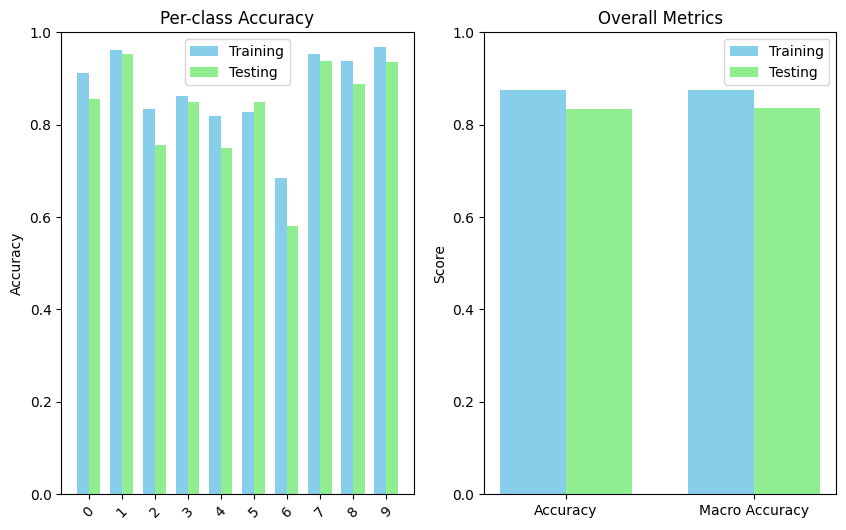

In [91]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plot_metrics(metrics_fas_train, ins_metrics, class_names=class_names)